# **EDA for Stock1**

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import r2_score
import random
from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import clone
from joblib import Parallel, delayed
from xgboost import XGBRegressor
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import warnings

In [115]:
stock1 = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_1.csv")
stock1.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100,1
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,1
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,1
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,1
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,1


In [116]:
if (stock1["stock_id"].unique()) == 1:
    del stock1["stock_id"]
    stock1['time_id'] = pd.factorize(stock1['time_id'])[0] + 1
stock1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507532 entries, 0 to 1507531
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   time_id            1507532 non-null  int64  
 1   seconds_in_bucket  1507532 non-null  int64  
 2   bid_price1         1507532 non-null  float64
 3   ask_price1         1507532 non-null  float64
 4   bid_price2         1507532 non-null  float64
 5   ask_price2         1507532 non-null  float64
 6   bid_size1          1507532 non-null  int64  
 7   ask_size1          1507532 non-null  int64  
 8   bid_size2          1507532 non-null  int64  
 9   ask_size2          1507532 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 115.0 MB


## **TimeIDs and Buckets**

In [117]:
len(stock1["time_id"].unique())

3830

In [118]:
seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique()
print("Number of Seconds with Data per Time_ID:")
print(seconds_per_time_id)

Number of Seconds with Data per Time_ID:
time_id
1       575
2       370
3       353
4       171
5       227
       ... 
3826    307
3827    494
3828    313
3829    434
3830    305
Name: seconds_in_bucket, Length: 3830, dtype: int64


In [119]:
expected_seconds = 600
missing_seconds = expected_seconds - seconds_per_time_id
high_missing_threshold = 0.7 * expected_seconds 
high_missing_time_ids = missing_seconds[missing_seconds > high_missing_threshold]

print("Time IDs with 70% or more missing seconds:")
print(high_missing_time_ids.sort_values(ascending=False))

Time IDs with 70% or more missing seconds:
time_id
3312    468
1094    466
1687    465
3578    462
2965    461
2556    455
1843    454
784     451
821     450
278     446
356     446
2504    442
3530    441
1035    439
253     438
2954    437
433     436
1465    436
1629    436
3143    435
2849    434
3064    433
3346    433
3605    432
2761    431
1914    431
346     431
192     431
4       429
104     429
84      428
1836    427
2511    427
2374    427
1202    426
2429    426
2282    426
525     426
2933    426
651     425
3174    425
3558    425
2394    425
910     424
1669    424
1332    423
2357    423
965     422
2223    421
2939    421
2631    421
1717    421
Name: seconds_in_bucket, dtype: int64


In [120]:
high_missing_time_ids = missing_seconds[missing_seconds > high_missing_threshold].index
filtered_stock1 = stock1[~stock1["time_id"].isin(high_missing_time_ids)]
filtered_stock1.shape

(1498949, 10)

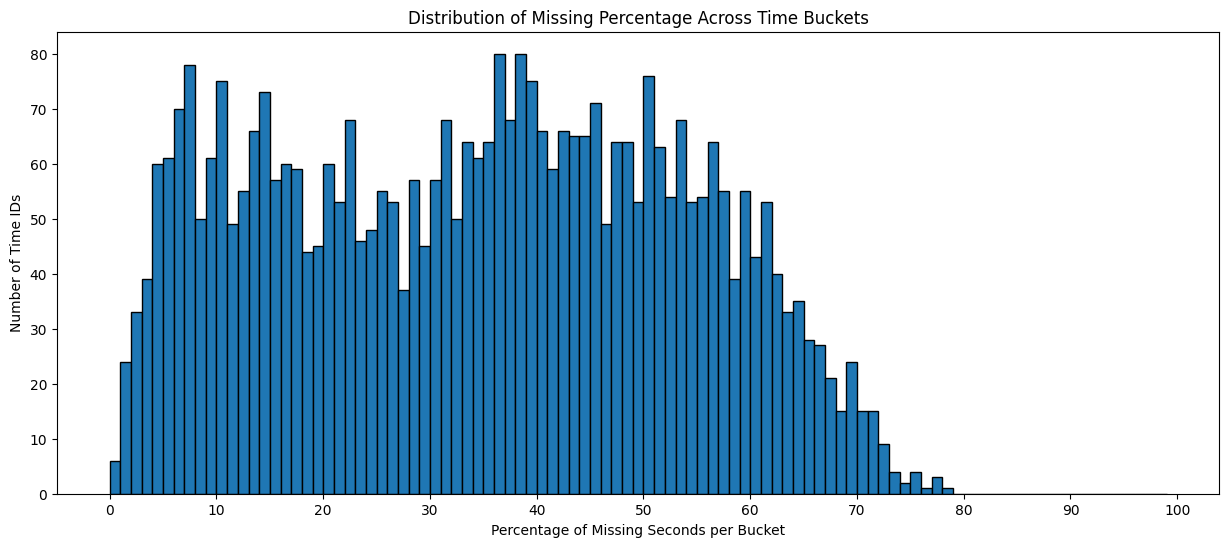

In [121]:
missing_percentage = (missing_seconds / expected_seconds) * 100
plt.figure(figsize=(15, 6))
bins = np.arange(0, 100, 1)
plt.hist(missing_percentage, bins=bins, edgecolor='black')
plt.xlabel("Percentage of Missing Seconds per Bucket")
plt.ylabel("Number of Time IDs")
plt.title("Distribution of Missing Percentage Across Time Buckets")
plt.xticks(np.arange(0, 105, 10))
plt.show()

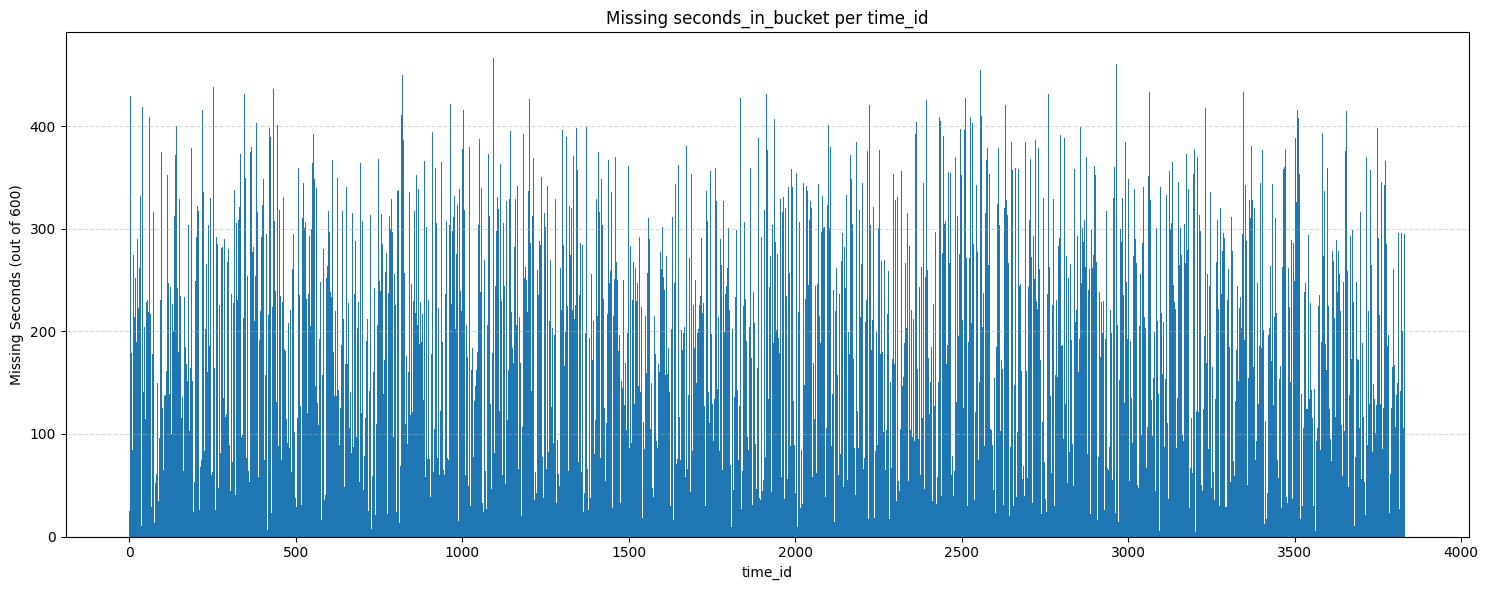

In [122]:
expected_seconds = set(range(600)) 
missing_counts = (
    stock1.groupby("time_id")["seconds_in_bucket"]
    .apply(lambda x: 600 - len(set(x)))
    .reset_index(name="missing_seconds")
)

plt.figure(figsize=(15, 6))
plt.bar(missing_counts["time_id"], missing_counts["missing_seconds"], width=1.0)
plt.xlabel("time_id")
plt.ylabel("Missing Seconds (out of 600)")
plt.title("Missing seconds_in_bucket per time_id")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

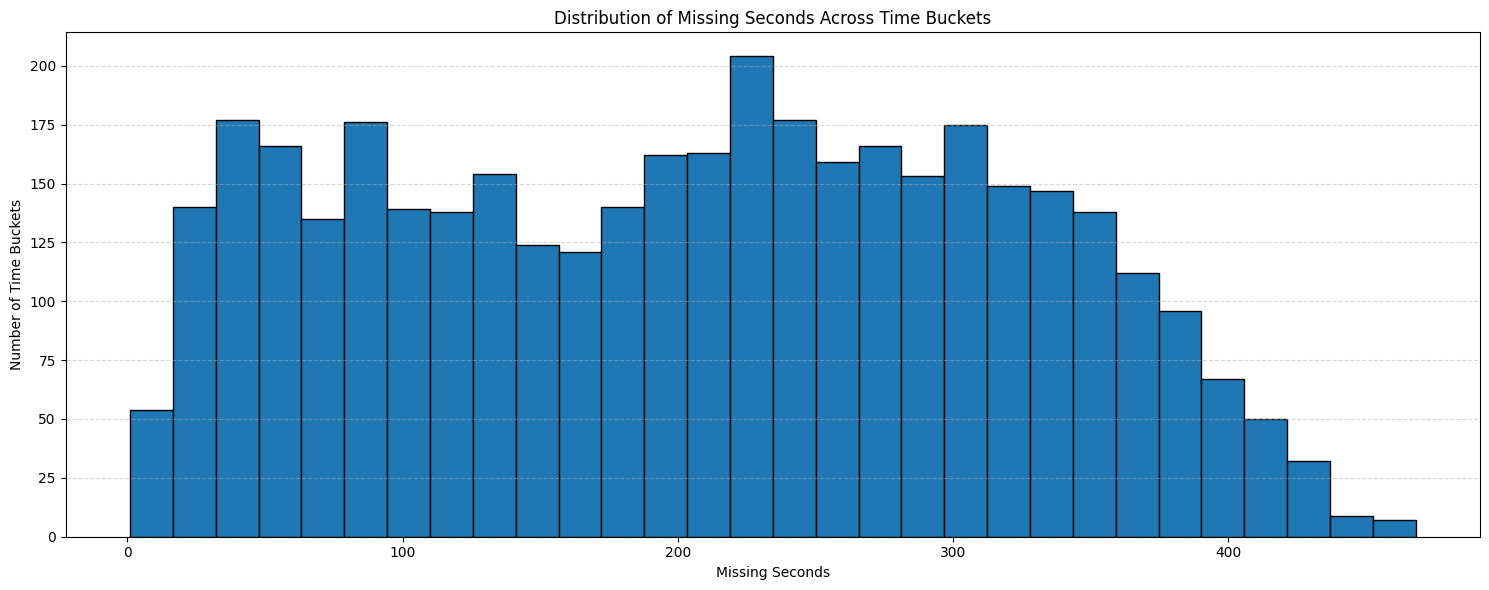

In [123]:
plt.figure(figsize=(15, 6))
plt.hist(missing_counts["missing_seconds"], bins=30, edgecolor='black')
plt.xlabel("Missing Seconds")
plt.ylabel("Number of Time Buckets")
plt.title("Distribution of Missing Seconds Across Time Buckets")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Patterns in Missing Data**

In [124]:
df_copy = stock1.copy()

all_seconds = np.arange(0, 600)
time_ids = df_copy['time_id'].unique()
full_index = pd.MultiIndex.from_product([time_ids, all_seconds],names=['time_id', 'seconds_in_bucket'])
df_full = pd.DataFrame(index=full_index).reset_index()
df_merged = pd.merge(df_full, df_copy, on=['time_id', 'seconds_in_bucket'], how='left')
non_key_columns = [col for col in df_copy.columns if col not in ['time_id', 'seconds_in_bucket']]
df_merged['missing_indicator'] = df_merged[non_key_columns].isna().all(axis=1).astype(int)
df_merged

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,missing_indicator
0,1,0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0,0
1,1,1,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0,0
2,1,2,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0,0
3,1,3,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0,0
4,1,4,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2297995,3830,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297996,3830,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297997,3830,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297998,3830,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [125]:
def little_mcar_test(df, cols):

    df_subset = df[cols]
    complete_data = df_subset.dropna()
    overall_mean = complete_data.mean()
    cov_matrix = complete_data.cov()

    missing_patterns = df_subset.isnull().astype(int).drop_duplicates()
    
    chi2_stat = 0.0
    df_total = 0
    
    for idx, pattern in missing_patterns.iterrows():
        mask = (df_subset.isnull().astype(int) == pattern).all(axis=1)
        subset = df_subset[mask]
        n = subset.shape[0]
        observed_vars = pattern[pattern == 0].index.tolist()
        if len(observed_vars) == 0:
            continue
        
        group_mean = subset[observed_vars].mean()
        delta = (group_mean - overall_mean[observed_vars]).values.reshape(-1, 1)
        cov_sub = cov_matrix.loc[observed_vars, observed_vars].values
        inv_cov = np.linalg.pinv(cov_sub)
        
        t_stat = n * (delta.T @ inv_cov @ delta)
        chi2_stat += t_stat[0, 0]
        df_total += len(observed_vars)
    
    p_value = stats.chi2.sf(chi2_stat, df_total)
    return chi2_stat, df_total, p_value

chi2, dof, pval = little_mcar_test(df_merged, ['missing_indicator'])
print("\nLittle's MCAR Test Results:")
print(f"Chi2 Statistic: {chi2:.3f}, Degrees of Freedom: {dof}, p-value: {pval:.3f}")


Little's MCAR Test Results:
Chi2 Statistic: 0.000, Degrees of Freedom: 1, p-value: 1.000


In [126]:
logit_model = smf.logit('missing_indicator ~ seconds_in_bucket', data=df_merged).fit(disp=False)
print("\nLogistic Regression Summary for Missing Indicator:")
print(logit_model.summary())


Logistic Regression Summary for Missing Indicator:
                           Logit Regression Results                           
Dep. Variable:      missing_indicator   No. Observations:              2298000
Model:                          Logit   Df Residuals:                  2297998
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Apr 2025   Pseudo R-squ.:               0.0002338
Time:                        00:14:53   Log-Likelihood:            -1.4787e+06
converged:                       True   LL-Null:                   -1.4791e+06
Covariance Type:            nonrobust   LLR p-value:                2.102e-152
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7090      0.003   -254.261      0.000      -0.714      -0.704
seconds_in_bucket     0.0002   8.02e-06     26.292      0.

In [127]:
pivot_table = df_merged.pivot(index='time_id', columns='seconds_in_bucket', values='missing_indicator')
pivot_table = pivot_table.fillna(0)
pivot_table['missing_rate'] = pivot_table.mean(axis=1)
seconds_columns = list(all_seconds)  
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pivot_table[seconds_columns])
pivot_table['cluster'] = clusters
cluster_summary = pivot_table.groupby('cluster')['missing_rate'].mean()
print("\nCluster Summary (Average Missing Rate by Cluster):")
print(cluster_summary)


Cluster Summary (Average Missing Rate by Cluster):
cluster
0     0.085829
1     0.559792
2     0.526667
3     0.666741
4     0.406858
5     0.588287
6     0.523810
7     0.612662
8     0.538099
9     0.326181
10    0.462451
11    0.546667
12    0.511000
13    0.548238
14    0.538141
15    0.508851
16    0.483333
17    0.486979
18    0.578333
19    0.521542
20    0.639822
21    0.590833
22    0.416245
23    0.209546
24    0.473788
25    0.497654
26    0.527523
27    0.476778
28    0.594111
29    0.524653
Name: missing_rate, dtype: float64


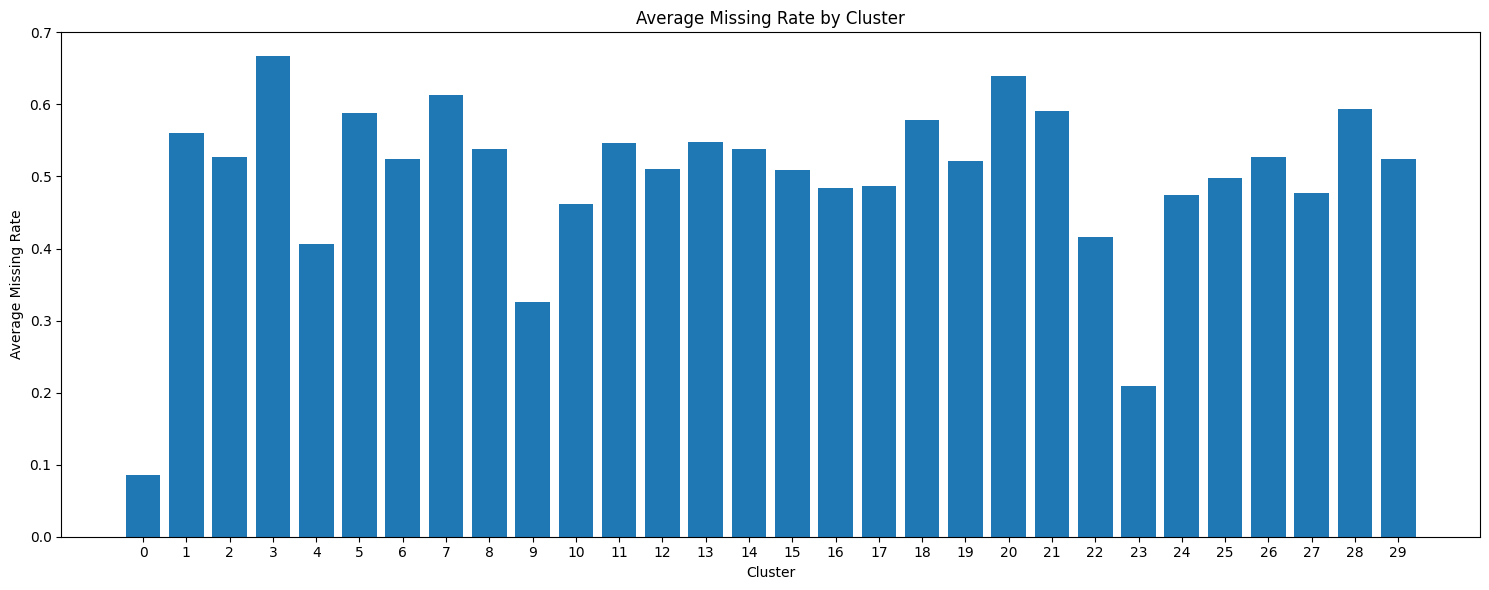

In [128]:
plt.figure(figsize=(15, 6))
plt.bar(cluster_summary.index.astype(str), cluster_summary.values)
plt.xlabel("Cluster")
plt.ylabel("Average Missing Rate")
plt.title("Average Missing Rate by Cluster")
plt.tight_layout()
plt.show()

In [129]:
del df_copy, df_merged

## **Handling Missing Data**

#### **Adding Missing Rows with NaNs**

In [130]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reindex_group(group):
    group = group.set_index('seconds_in_bucket').sort_index()
    complete_index = range(600)
    group = group.reindex(complete_index)
    group['time_id'] = group['time_id'].ffill().astype(int)
    result = group.reset_index().rename(columns={'index': 'seconds_in_bucket'})
    result = result[['time_id', 'seconds_in_bucket'] + [col for col in result.columns 
                                                        if col not in ('time_id', 'seconds_in_bucket')]]
    return result

df_complete = stock1.groupby('time_id', group_keys=False).apply(reindex_group).reset_index(drop=True)
df_complete

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,1,0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0
1,1,1,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0
2,1,2,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0
3,1,3,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0
4,1,4,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...
2297995,3830,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297996,3830,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297997,3830,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297998,3830,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
counts = df_complete.groupby('time_id')['seconds_in_bucket'].count()
print(counts.unique())

[600]


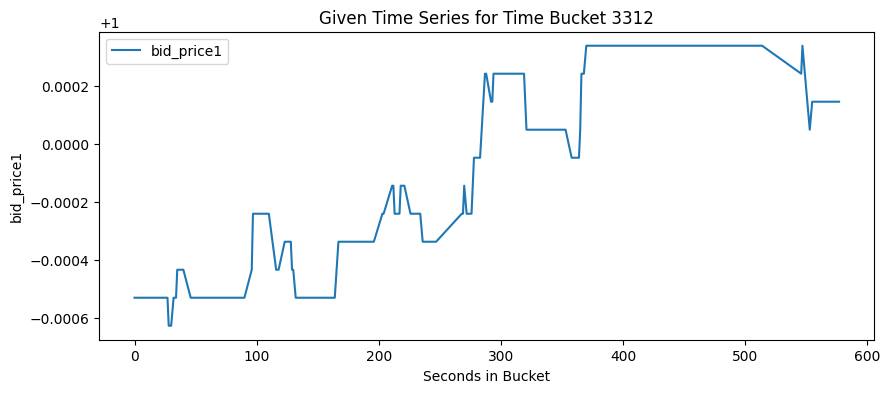

In [132]:
bucket_id = stock1['time_id'].unique()[3311]
bucket_data = stock1[stock1['time_id'] == bucket_id]

plt.figure(figsize=(10, 4))
plt.plot(bucket_data['seconds_in_bucket'], bucket_data['ask_price1'], label='bid_price1')
plt.xlabel('Seconds in Bucket')
plt.ylabel('bid_price1')
plt.title(f'Given Time Series for Time Bucket {bucket_id}')
plt.legend()
plt.show()

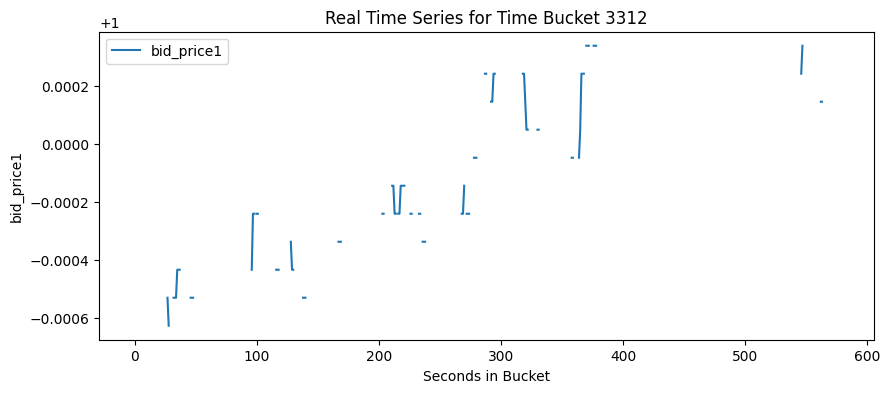

In [133]:
bucket_id = df_complete['time_id'].unique()[3311]
bucket_data = df_complete[df_complete['time_id'] == bucket_id]

plt.figure(figsize=(10, 4))
plt.plot(bucket_data['seconds_in_bucket'], bucket_data['ask_price1'], label='bid_price1')
plt.xlabel('Seconds in Bucket')
plt.ylabel('bid_price1')
plt.title(f'Real Time Series for Time Bucket {bucket_id}')
plt.legend()
plt.show()

#### **Removing High Missing Time_IDs and Imputing Low Missing Time_IDs**

In [134]:
def remove_timeIDs(percent: float = 0.7):

    seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique()
    expected_seconds = 600
    missing_seconds = expected_seconds - seconds_per_time_id
    high_missing_threshold = percent * expected_seconds 

    rem_time_ids = missing_seconds[missing_seconds > high_missing_threshold].index
    df_processed = df_complete[~df_complete["time_id"].isin(rem_time_ids)].copy() 
    df_processed['time_id'] = pd.factorize(df_processed['time_id'])[0] + 1
    
    return df_processed

df_processed = remove_timeIDs()
df_processed

# Is removing Time_IDs okay? How would this affect model accuracy? Is Re-labelling okay or shall I leave the lables?

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,1,0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0
1,1,1,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0
2,1,2,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0
3,1,3,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0
4,1,4,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...
2297995,3778,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297996,3778,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297997,3778,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297998,3778,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
def impute_timeIDs(df, percent: float = 0.3):

    groups = []
    expected_seconds = 600
    allowed_missing = percent * expected_seconds 

    for time_id, group in df.groupby("time_id"):
        unique_secs = group["seconds_in_bucket"].nunique()
        missing_count = expected_seconds - unique_secs
        
        if missing_count <= allowed_missing:

            full_index = range(expected_seconds)
            group_temp = group.set_index("seconds_in_bucket")
            group_temp = group_temp.reindex(full_index)
            
            group_temp["time_id"] = time_id
            group_temp["seconds_in_bucket"] = group_temp.index
            
            numeric_cols = group_temp.select_dtypes(include=["number"]).columns
            group_temp[numeric_cols] = group_temp[numeric_cols].interpolate(method="linear")
            
            group_temp = group_temp.ffill().bfill()
            groups.append(group_temp.reset_index(drop=True))
        else:
            groups.append(group)
    
    return pd.concat(groups, ignore_index=True)

df_processed_imputed = impute_timeIDs(df_processed)
df_complete_imputed = impute_timeIDs(df_complete)

## **Comparing Dataframes**

In [136]:
stock1.columns # Original Dataset

Index(['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2'],
      dtype='object')

In [137]:
df_complete.columns # Re-labled, Added missing Seconds, not Imputed, has NaNs

Index(['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2'],
      dtype='object')

In [138]:
df_processed.columns # Re-labled, Added missing Seconds, not Imputed, has NaNs, Removed High Missing Time_IDs

Index(['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2'],
      dtype='object')

In [139]:
df_processed_imputed.columns # Re-labled, Added missing Seconds, Imputed, Removed High Missing Time_IDs

Index(['time_id', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
       'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2',
       'seconds_in_bucket'],
      dtype='object')

In [143]:
df_complete_imputed.columns # # Re-labled, Added missing Seconds, Imputed

Index(['time_id', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
       'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2',
       'seconds_in_bucket'],
      dtype='object')

In [141]:
filtered_stock1.columns # Removed High Missing Time_IDs

Index(['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2'],
      dtype='object')

#### **Weighted Linear Regression**

In [144]:
def evaluate_vol_prediction_weighted_lr(df):
    df = df.sort_values(by='time_id').reset_index(drop=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_col = 'realized_volatility'
    exclude_cols = ['time_id', 'seconds_in_bucket', target_col]
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]
    
    X = df[feature_cols].fillna(0)
    y = df[target_col].fillna(0)
    weights = df["bid_size1"] + df["ask_size1"]
    
    train_size = int(len(df) * 0.7)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    weights_train, weights_test = weights.iloc[:train_size], weights.iloc[train_size:]
    
    X_train_const = sm.add_constant(X_train)
    model = sm.WLS(y_train, X_train_const, weights=weights_train)
    results = model.fit()
    
    X_test_const = sm.add_constant(X_test)
    y_pred = results.predict(X_test_const)
    r2 = r2_score(y_test, y_pred)
    
    return r2, results

In [145]:
random.seed(3888)

targets = [stock1, df_complete, df_processed, df_processed_imputed, df_complete_imputed, filtered_stock1]
for i in range(len(targets)):
    df = targets[i].copy()  

    df.loc[:, "midpoint"] = (df["ask_price1"] + df["bid_price1"]) / 2
    df.loc[:, "bid_ask_spread"] = df["ask_price1"] - df["bid_price1"]
    df.loc[:, "log_return"] = np.log(df["midpoint"]).diff()
    df.loc[:, "realized_volatility"] = df["log_return"].rolling(window=30).apply(
        lambda x: np.sqrt(np.sum(x**2)), raw=True
    )
    df.dropna(inplace=True)

    r2_weighted_lr, lr_results = evaluate_vol_prediction_weighted_lr(df)
    print("Weighted Linear Regression R^2:", r2_weighted_lr)

Weighted Linear Regression R^2: 0.09710480939069632
Weighted Linear Regression R^2: 0.19896439116633702
Weighted Linear Regression R^2: 0.1965152249660368
Weighted Linear Regression R^2: 0.042381569264582586
Weighted Linear Regression R^2: 0.0436385720253446
Weighted Linear Regression R^2: 0.09689431699584927


#### **Hist Gradient Boosting**

In [146]:
def evaluate_vol_prediction_hgb_cv(df, n_splits=10, rolling_window=None):

    df = df.sort_values(by='time_id').reset_index(drop=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_col = 'realized_volatility'
    exclude_cols = ['time_id', 'seconds_in_bucket', target_col]
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]

    X = df[feature_cols].fillna(0)
    y = df[target_col].fillna(0)
    sample_weight = df["bid_size1"] + df["ask_size1"]
    
    base_model = HistGradientBoostingRegressor(
        random_state=3888,
        early_stopping=True,
        max_iter=1000,       
        learning_rate=0.001, 
        max_depth=10        
    )
    
    if rolling_window is not None:
        tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=rolling_window)
    else:
        tscv = TimeSeriesSplit(n_splits=n_splits)

    def fold_score(train_index, val_index):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        weights_train = sample_weight.iloc[train_index]
        model_fold = clone(base_model)
        model_fold.fit(X_train, y_train, sample_weight=weights_train)
        y_pred = model_fold.predict(X_val)
        return r2_score(y_val, y_pred)

    scores = Parallel(n_jobs=-1)(
        delayed(fold_score)(train_index, val_index)
        for train_index, val_index in tscv.split(X)
    )
    
    avg_r2 = np.mean(scores)

    final_model = clone(base_model)
    final_model.fit(X, y, sample_weight=sample_weight)
    
    return avg_r2, final_model

In [147]:
random.seed(3888)

targets = [stock1, df_complete, df_processed, df_processed_imputed, df_complete_imputed, filtered_stock1]
for i in range(len(targets)):
    df = targets[i].copy()  

    df.loc[:, "midpoint"] = (df["ask_price1"] + df["bid_price1"]) / 2
    df.loc[:, "bid_ask_spread"] = df["ask_price1"] - df["bid_price1"]
    df.loc[:, "log_return"] = np.log(df["midpoint"]).diff()
    df.loc[:, "realized_volatility"] = df["log_return"].rolling(window=30).apply(
        lambda x: np.sqrt(np.sum(x**2)), raw=True
    )
    df.dropna(inplace=True)

    r2_hgb, hgb_model = evaluate_vol_prediction_hgb_cv(df, rolling_window = 30)
    print("Hist-Gradient-Boosting-Regressor R^2:", r2_hgb)

Hist-Gradient-Boosting-Regressor R^2: -0.35561430596253507
Hist-Gradient-Boosting-Regressor R^2: -0.14250742030335364
Hist-Gradient-Boosting-Regressor R^2: -0.15451380355018546
Hist-Gradient-Boosting-Regressor R^2: -0.12651301952409197
Hist-Gradient-Boosting-Regressor R^2: -0.1214909670731916
Hist-Gradient-Boosting-Regressor R^2: -0.08146742877336074


#### **XGBoost**

In [151]:
def evaluate_vol_prediction_xgb_cv(df, n_splits=5):

    df = df.sort_values(by='time_id').reset_index(drop=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_col = 'realized_volatility'
    exclude_cols = ['time_id', 'seconds_in_bucket', target_col]
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]

    X = df[feature_cols].fillna(0)
    y = df[target_col].fillna(0)
    
    epsilon = 1e-9
    sample_weight = (df["bid_size1"] + df["ask_size1"]).clip(lower=epsilon)
    
    base_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=8,
        random_state=3888,
        early_stopping_rounds=20,
        verbosity=0
    )
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    def fold_score(train_index, val_index):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        weights_train = sample_weight.iloc[train_index]
        
        model_fold = clone(base_model)
        model_fold.fit(
            X_train,
            y_train, 
            sample_weight=weights_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        y_pred = model_fold.predict(X_val)
        return r2_score(y_val, y_pred)
    
    scores = Parallel(n_jobs=-1)(
        delayed(fold_score)(train_index, val_index)
        for train_index, val_index in tscv.split(X)
    )
    
    avg_r2 = np.mean(scores)
    
    final_model = clone(base_model)
    final_model.set_params(early_stopping_rounds=None)  
    final_model.fit(X, y, sample_weight=sample_weight)
    
    return avg_r2, final_model

In [152]:
random.seed(3888)

targets = [stock1, df_complete, df_processed, df_processed_imputed, df_complete_imputed, filtered_stock1]
for i in range(len(targets)):
    df = targets[i].copy()  

    df.loc[:, "midpoint"] = (df["ask_price1"] + df["bid_price1"]) / 2
    df.loc[:, "bid_ask_spread"] = df["ask_price1"] - df["bid_price1"]
    df.loc[:, "log_return"] = np.log(df["midpoint"]).diff()
    df.loc[:, "realized_volatility"] = df["log_return"].rolling(window=30).apply(
        lambda x: np.sqrt(np.sum(x**2)), raw=True
    )
    df.dropna(inplace=True)

    r2_xgb, xgb_model = evaluate_vol_prediction_xgb_cv(df)
    print("XGBoost Regressor R^2:", r2_xgb)

XGBoost Regressor R^2: 0.11946970790834321
XGBoost Regressor R^2: 0.17526579074648085
XGBoost Regressor R^2: 0.17458450946256013
XGBoost Regressor R^2: 0.088852227451207
XGBoost Regressor R^2: 0.0909668507862881
XGBoost Regressor R^2: 0.11736578497517633


## **Misc Techniques**

#### **Making DFs**

In [171]:
def reindex_group_linear(group):
    group = group.set_index('seconds_in_bucket').sort_index()
    complete_index = range(600)
    group = group.reindex(complete_index)
    group['time_id'] = group['time_id'].ffill().astype(int)
    numeric_cols = group.select_dtypes(include=[np.number]).columns.drop('time_id')
    group[numeric_cols] = group[numeric_cols].interpolate(method='linear')

    return group.reset_index().rename(columns={'index': 'seconds_in_bucket'})

df_linear = stock1.groupby('time_id', group_keys=False).apply(reindex_group_linear).reset_index(drop=True).copy()

In [190]:
def reindex_group_polynomial(group, order=2):
    group = group.set_index('seconds_in_bucket').sort_index()
    complete_index = range(600)
    group = group.reindex(complete_index)
    group['time_id'] = group['time_id'].ffill().astype(int)
    numeric_cols = group.select_dtypes(include=[np.number]).columns.drop('time_id')
    group[numeric_cols] = group[numeric_cols].interpolate(method='polynomial', order=order)
    
    return group.reset_index().rename(columns={'index': 'seconds_in_bucket'})

df_polynomial = stock1.groupby('time_id', group_keys=False).apply(reindex_group_polynomial).reset_index(drop=True).copy()

In [173]:
def process_group_bayesian(group):
    group = group.set_index('seconds_in_bucket').sort_index()
    complete_index = range(600)
    group = group.reindex(complete_index)
    group['time_id'] = group['time_id'].ffill().astype(int)
    numeric_cols = group.select_dtypes(include=[np.number]).columns.drop('time_id')
    imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42)
    group[numeric_cols] = imputer.fit_transform(group[numeric_cols])

    return group.reset_index().rename(columns={'index': 'seconds_in_bucket'})

df_bayesian = stock1.groupby('time_id', group_keys=False).apply(process_group_bayesian).reset_index(drop=True).copy()

#### **Plotting**

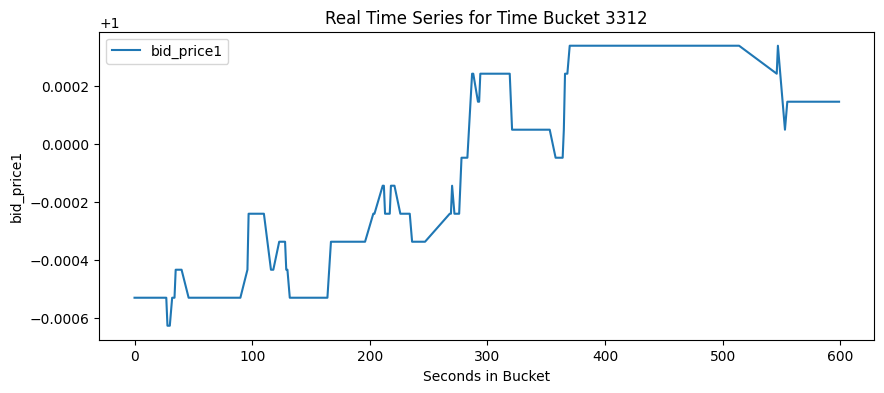

In [174]:
bucket_id = df_linear['time_id'].unique()[3311]
bucket_data = df_linear[df_linear['time_id'] == bucket_id]

plt.figure(figsize=(10, 4))
plt.plot(bucket_data['seconds_in_bucket'], bucket_data['ask_price1'], label='bid_price1')
plt.xlabel('Seconds in Bucket')
plt.ylabel('bid_price1')
plt.title(f'Real Time Series for Time Bucket {bucket_id}')
plt.legend()
plt.show()

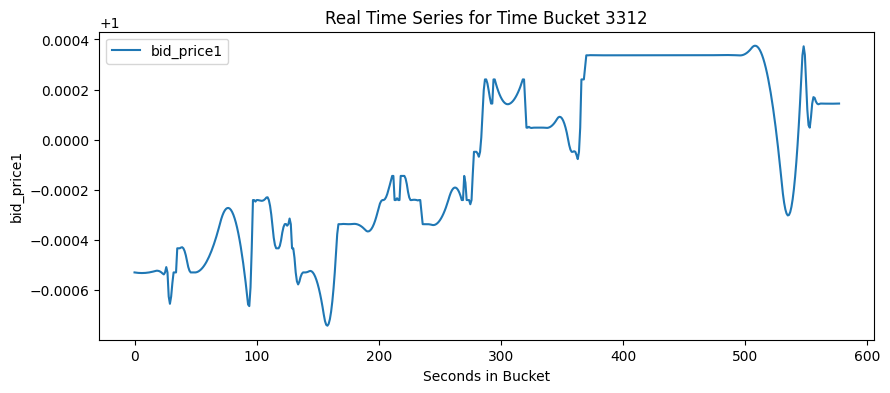

In [179]:
bucket_id = df_polynomial['time_id'].unique()[3311]
bucket_data = df_polynomial[df_polynomial['time_id'] == bucket_id]

plt.figure(figsize=(10, 4))
plt.plot(bucket_data['seconds_in_bucket'], bucket_data['ask_price1'], label='bid_price1')
plt.xlabel('Seconds in Bucket')
plt.ylabel('bid_price1')
plt.title(f'Real Time Series for Time Bucket {bucket_id}')
plt.legend()
plt.show()

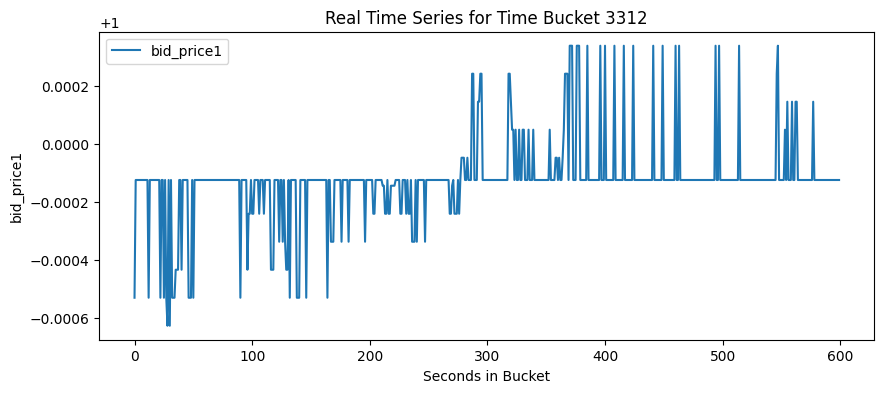

In [176]:
bucket_id = df_bayesian['time_id'].unique()[3311]
bucket_data = df_bayesian[df_bayesian['time_id'] == bucket_id]

plt.figure(figsize=(10, 4))
plt.plot(bucket_data['seconds_in_bucket'], bucket_data['ask_price1'], label='bid_price1')
plt.xlabel('Seconds in Bucket')
plt.ylabel('bid_price1')
plt.title(f'Real Time Series for Time Bucket {bucket_id}')
plt.legend()
plt.show()

## **Manual Feature Engineering**

In [149]:
stock1["midpoint"] = (stock1["ask_price1"] + stock1["bid_price1"]) / 2
stock1["bid_ask_spread"] = stock1["ask_price1"] - stock1["bid_price1"]
stock1["log_return"] = np.log(stock1["midpoint"]).diff()
stock1["realized_volatility"] = stock1["log_return"].rolling(window=20).apply(
    lambda x: np.sqrt(np.sum(x**2)), raw=True
)
stock1.dropna(inplace=True)

In [150]:
print(stock1.head(n=10).to_string())

    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  midpoint  bid_ask_spread  log_return  realized_volatility
20        1                 21    1.001017    1.001870    1.000886    1.001936         26         24         25        100  1.001443        0.000853    0.000000             0.000234
21        1                 22    1.001017    1.001870    1.000886    1.001936         27         24         25        100  1.001443        0.000853    0.000000             0.000225
22        1                 23    1.001214    1.001870    1.001148    1.001936         25         24        125        100  1.001542        0.000656    0.000098             0.000207
23        1                 24    1.001214    1.001870    1.001148    1.001936         33         24        125        100  1.001542        0.000656    0.000000             0.000197
24        1                 25    1.001214    1.001870    1.001148    1.001936         33 